<a href="https://colab.research.google.com/github/dcpatton/keras_tuner/blob/master/keras_tuning_part4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import random

seed = 52
tf.random.set_seed(seed)
random.seed(seed)

print('TensorFlow version = ' + tf.__version__)

accuracies = [] # for metric tracking

TensorFlow version = 2.3.0


In [ ]:
!pip install keras-tuner -q
import kerastuner as kt
print('Keras Tuner version = ' + kt.__version__)

     |████████████████████████████████| 61kB 4.9MB/s 
Keras Tuner version = 1.0.1


## Load CIFAR10

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
# Normalize the data
train_images, test_images = train_images / 255.0, test_images / 255.0

170500096/170498071 [==============================] - 6s 0us/step


In [ ]:
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

# Baseline

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, MaxPool2D, Dense
from tensorflow.keras import Input, Model

inp = Input(shape=(32, 32, 3), name='inp')
x = Conv2D(16, 3, activation='relu')(inp)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
out = Dense(10, activation='softmax')(x)

model = Model(inputs=[inp], outputs=[out])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
              metrics=['acc'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inp (InputLayer)             [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 64)         

In [ ]:
filepath = 'model.h5'
mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

history = model.fit(train_images, train_labels, epochs=200, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=2, batch_size=8)

Epoch 1/200
6250/6250 - 18s - loss: 1.5417 - acc: 0.4367 - val_loss: 1.3074 - val_acc: 0.5258
Epoch 2/200
6250/6250 - 18s - loss: 1.2058 - acc: 0.5702 - val_loss: 1.1273 - val_acc: 0.6004
Epoch 3/200
6250/6250 - 18s - loss: 1.0827 - acc: 0.6173 - val_loss: 1.0635 - val_acc: 0.6216
Epoch 4/200
6250/6250 - 18s - loss: 1.0051 - acc: 0.6466 - val_loss: 1.0197 - val_acc: 0.6421
Epoch 5/200
6250/6250 - 18s - loss: 0.9475 - acc: 0.6655 - val_loss: 1.0516 - val_acc: 0.6359
Epoch 6/200
6250/6250 - 18s - loss: 0.9065 - acc: 0.6784 - val_loss: 1.0328 - val_acc: 0.6380
Epoch 7/200
6250/6250 - 18s - loss: 0.8722 - acc: 0.6929 - val_loss: 0.9789 - val_acc: 0.6525
Epoch 8/200
6250/6250 - 18s - loss: 0.8417 - acc: 0.7034 - val_loss: 0.9983 - val_acc: 0.6631
Epoch 9/200
6250/6250 - 18s - loss: 0.8151 - acc: 0.7127 - val_loss: 1.0119 - val_acc: 0.6499
Epoch 10/200
6250/6250 - 18s - loss: 0.7907 - acc: 0.7218 - val_loss: 0.9750 - val_acc: 0.6647
Epoch 11/200
6250/6250 - 18s - loss: 0.7656 - acc: 0.7299 -

In [ ]:
model.load_weights(filepath)
metrics = model.evaluate(test_images, test_labels, verbose=0)
print('Loss = ' + str(metrics[0]))
print('Accuracy = ' + str(metrics[1]))
accuracies.append(metrics[1])

Loss = 0.9750430583953857
Accuracy = 0.6646999716758728


# Hyperband Tuner

In [ ]:
def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  x = Conv2D(hp.Int('f_1', 16, 96, 16), 3, activation='relu')(inp)
  x = MaxPool2D()(x)
  x = Conv2D(hp.Int('f_2', 32, 128, 32), 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(hp.Int('f_3', 64, 128, 32), 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dense(hp.Int('h_1', 64, 512, 64), activation='relu')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [ ]:
import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
# helper function to perform tuning
def tune():

  tuner = kt.Hyperband(hypermodel=build_hypermodel, 
                     objective='val_loss', 
                     max_epochs=100, 
                     factor=3, 
                     hyperband_iterations=1, 
                     directory='test_dir',
                     project_name='a',
                     seed=seed,
                     overwrite=True)
  
  es = tf.keras.callbacks.EarlyStopping(patience=10)
  tuner.search(train_images, train_labels, epochs=200, 
              validation_data=(test_images, test_labels), 
              verbose=0, callbacks=[es, ClearTrainingOutput()])
  
  return tuner

In [ ]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal filter sizes are {best_hps.get('f_1')}
, {best_hps.get('f_2')}, and {best_hps.get('f_3')}. The optimal hidden_units is {best_hps.get('h_1')}.
""")


The hyperparameter search is complete. The optimal filter sizes are 32
, 128, and 128. The optimal hidden_units is 256.



In [ ]:
def train(model):
  mc = tf.keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                        save_weights_only=True)
  es = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

  history = model.fit(train_images, train_labels, epochs=200, 
                    validation_data=(test_images, test_labels), 
                    callbacks=[mc, es], verbose=2, batch_size=8)
  return history

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
history = train(model)

Epoch 1/200
6250/6250 - 18s - loss: 1.4315 - acc: 0.4802 - val_loss: 1.1498 - val_acc: 0.5948
Epoch 2/200
6250/6250 - 18s - loss: 1.0620 - acc: 0.6284 - val_loss: 1.0545 - val_acc: 0.6316
Epoch 3/200
6250/6250 - 18s - loss: 0.9126 - acc: 0.6809 - val_loss: 1.0337 - val_acc: 0.6405
Epoch 4/200
6250/6250 - 18s - loss: 0.8139 - acc: 0.7157 - val_loss: 0.8752 - val_acc: 0.6969
Epoch 5/200
6250/6250 - 18s - loss: 0.7424 - acc: 0.7383 - val_loss: 0.8808 - val_acc: 0.6979
Epoch 6/200
6250/6250 - 18s - loss: 0.6810 - acc: 0.7607 - val_loss: 0.9369 - val_acc: 0.6913
Epoch 7/200
6250/6250 - 18s - loss: 0.6298 - acc: 0.7775 - val_loss: 0.9255 - val_acc: 0.6992
Epoch 8/200
6250/6250 - 18s - loss: 0.5833 - acc: 0.7944 - val_loss: 0.9351 - val_acc: 0.7007
Epoch 9/200
6250/6250 - 19s - loss: 0.5407 - acc: 0.8083 - val_loss: 1.0400 - val_acc: 0.6869
Epoch 10/200
6250/6250 - 18s - loss: 0.5048 - acc: 0.8201 - val_loss: 1.0098 - val_acc: 0.7046
Epoch 11/200
6250/6250 - 18s - loss: 0.4825 - acc: 0.8293 -

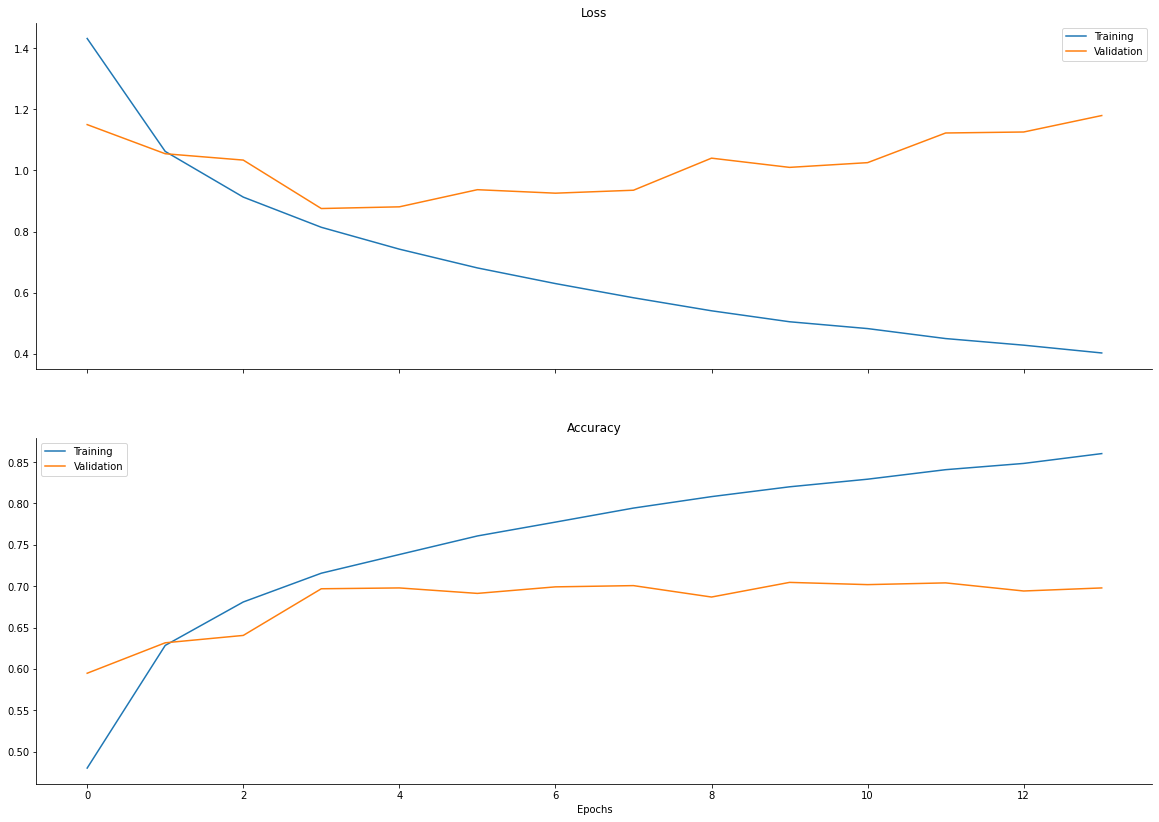

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_training(history):

  history = history.history

  fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

  ax1.plot(history['loss'], label='Training')
  ax1.plot(history['val_loss'], label='Validation')
  ax1.legend(loc='best')
  ax1.set_title('Loss')

  ax2.plot(history['acc'], label='Training')
  ax2.plot(history['val_acc'], label='Validation')
  ax2.legend(loc='best')
  ax2.set_title('Accuracy')

  plt.xlabel('Epochs')
  sns.despine()
  plt.show()

plot_training(history)

In [ ]:
def print_metrics():
  model.load_weights(filepath)
  metrics = model.evaluate(test_images, test_labels, verbose=0)
  print('Loss = ' + str(metrics[0]))
  print('Accuracy = ' + str(metrics[1]))
  accuracies.append(metrics[1])

print_metrics()

Loss = 0.8752447962760925
Accuracy = 0.6969000101089478


# Tune Dropout

In [ ]:
from tensorflow.keras.layers import Dropout

def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  x = Conv2D(48, 3, activation='relu')(inp)
  x = MaxPool2D()(x)
  x = Conv2D(96, 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  dp = hp.Float('dp_1', min_value=0.0, max_value=0.5, step=0.1)
  x = Dropout(dp)(x)
  x = Dense(512, activation='relu')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [ ]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal dropout size is {best_hps.get('dp_1')}.
""")


The hyperparameter search is complete. The optimal dropout size is 0.2.



Epoch 1/200
6250/6250 - 19s - loss: 1.5119 - acc: 0.4475 - val_loss: 1.3115 - val_acc: 0.5304
Epoch 2/200
6250/6250 - 18s - loss: 1.1786 - acc: 0.5814 - val_loss: 1.1293 - val_acc: 0.6084
Epoch 3/200
6250/6250 - 18s - loss: 1.0411 - acc: 0.6321 - val_loss: 1.0597 - val_acc: 0.6329
Epoch 4/200
6250/6250 - 18s - loss: 0.9522 - acc: 0.6643 - val_loss: 0.9123 - val_acc: 0.6781
Epoch 5/200
6250/6250 - 18s - loss: 0.8885 - acc: 0.6884 - val_loss: 0.9101 - val_acc: 0.6881
Epoch 6/200
6250/6250 - 18s - loss: 0.8379 - acc: 0.7048 - val_loss: 0.8875 - val_acc: 0.6983
Epoch 7/200
6250/6250 - 19s - loss: 0.8025 - acc: 0.7161 - val_loss: 0.9741 - val_acc: 0.6700
Epoch 8/200
6250/6250 - 19s - loss: 0.7688 - acc: 0.7299 - val_loss: 0.9028 - val_acc: 0.6903
Epoch 9/200
6250/6250 - 18s - loss: 0.7475 - acc: 0.7379 - val_loss: 0.9385 - val_acc: 0.6854
Epoch 10/200
6250/6250 - 18s - loss: 0.7218 - acc: 0.7483 - val_loss: 0.9034 - val_acc: 0.6965
Epoch 11/200
6250/6250 - 18s - loss: 0.6938 - acc: 0.7571 -

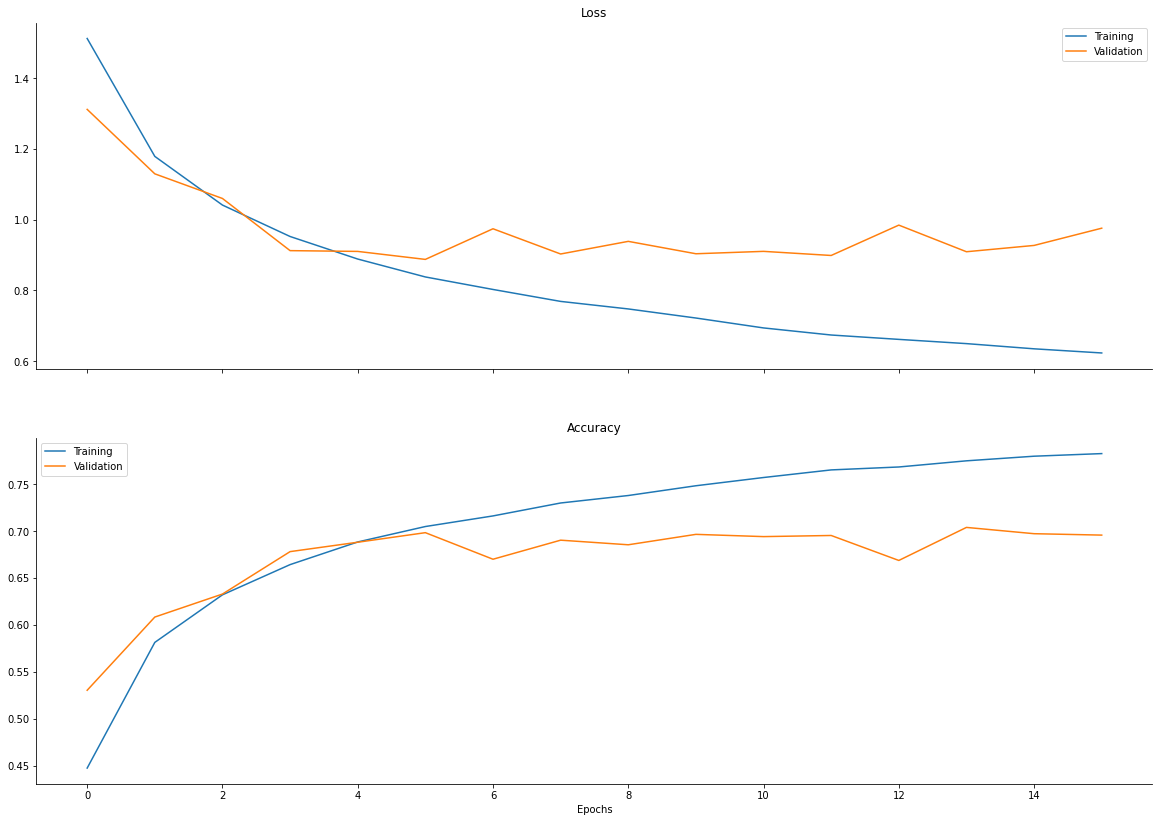

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = train(model)
plot_training(history)

In [ ]:
print_metrics()

Loss = 0.8874813318252563
Accuracy = 0.6983000040054321


# Tune Image Augmentation

In [ ]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
def build_hypermodel(hp):
  inp = Input(shape=(32, 32, 3), name='inp')
  f1 = hp.Float('f1', min_value=0.0, max_value=0.2, step=0.05)
  x = tf.keras.layers.experimental.preprocessing.RandomRotation(f1)(inp)
  x = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
  x = Conv2D(48, 3, activation='relu')(inp)
  x = MaxPool2D()(x)
  x = Conv2D(112, 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Conv2D(128, 3, activation='relu')(x)
  x = MaxPool2D()(x)
  x = Flatten()(x)
  x = Dropout(0.1)(x)
  x = Dense(512, activation='relu')(x)
  out = Dense(10, activation='softmax')(x)

  model = Model(inputs=[inp], outputs=[out])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False), 
                metrics=['acc'])

  return model

In [ ]:
tuner = tune()

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
print(f"""
The hyperparameter search is complete. The optimal rotation factor is {best_hps.get('f1')}.
""")


The hyperparameter search is complete. The optimal rotation factor is 0.15000000000000002.



Epoch 1/200
6250/6250 - 18s - loss: 1.7472 - acc: 0.3850 - val_loss: 1.4892 - val_acc: 0.4728
Epoch 2/200
6250/6250 - 18s - loss: 1.4941 - acc: 0.4719 - val_loss: 1.5122 - val_acc: 0.4576
Epoch 3/200
6250/6250 - 18s - loss: 1.4010 - acc: 0.5080 - val_loss: 1.3702 - val_acc: 0.5315
Epoch 4/200
6250/6250 - 18s - loss: 1.3345 - acc: 0.5326 - val_loss: 1.2687 - val_acc: 0.5525
Epoch 5/200
6250/6250 - 20s - loss: 1.2827 - acc: 0.5546 - val_loss: 1.2647 - val_acc: 0.5618
Epoch 6/200
6250/6250 - 18s - loss: 1.2429 - acc: 0.5699 - val_loss: 1.2603 - val_acc: 0.5807
Epoch 7/200
6250/6250 - 18s - loss: 1.2080 - acc: 0.5844 - val_loss: 1.2034 - val_acc: 0.5888
Epoch 8/200
6250/6250 - 18s - loss: 1.1976 - acc: 0.5932 - val_loss: 1.1814 - val_acc: 0.6001
Epoch 9/200
6250/6250 - 18s - loss: 1.1669 - acc: 0.6024 - val_loss: 1.3072 - val_acc: 0.5593
Epoch 10/200
6250/6250 - 18s - loss: 1.1491 - acc: 0.6102 - val_loss: 1.1777 - val_acc: 0.5990
Epoch 11/200
6250/6250 - 18s - loss: 1.1253 - acc: 0.6197 -

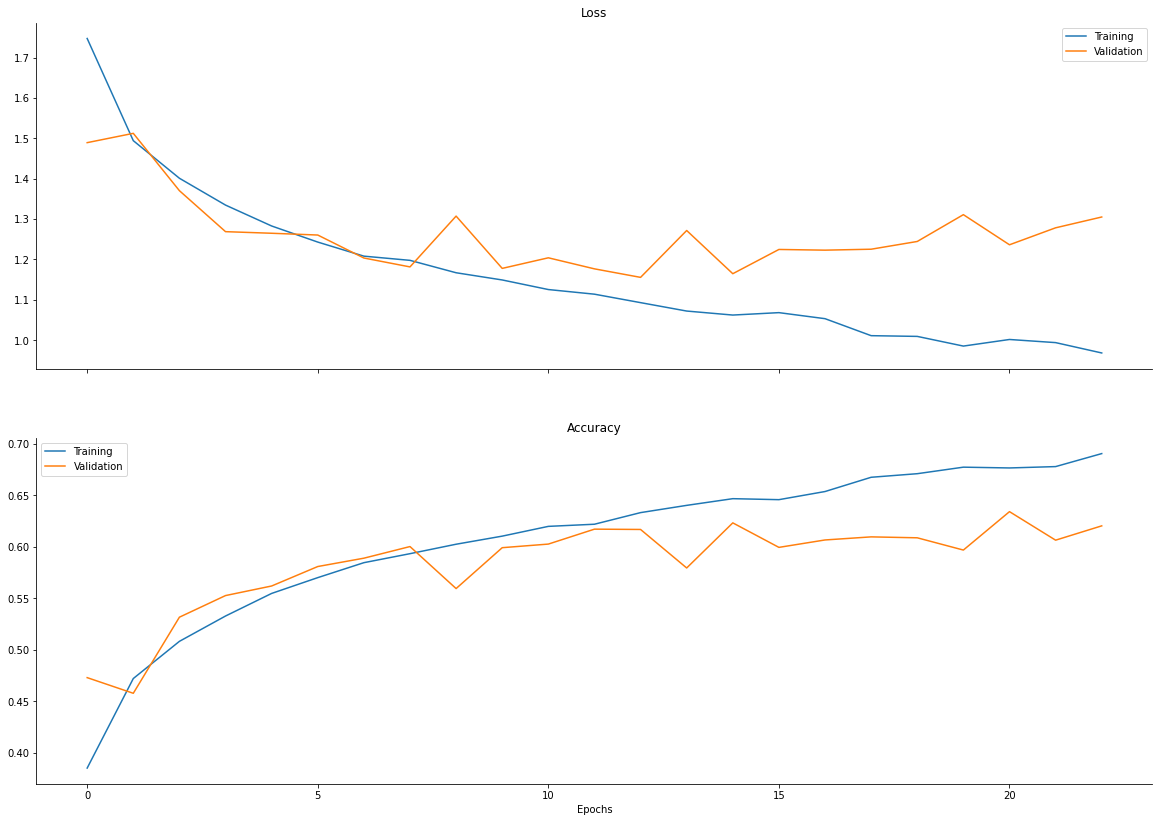

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = train(model)
plot_training(history)

In [ ]:
print_metrics()

Loss = 1.1554672718048096
Accuracy = 0.6166999936103821


# Results

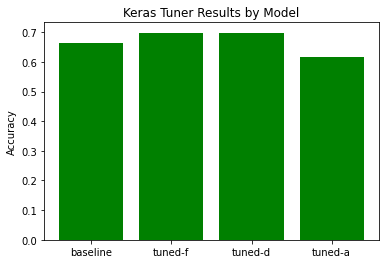

In [ ]:
labels = ['baseline', 'tuned-f', 'tuned-d', 'tuned-a']

x_pos = [i for i, _ in enumerate(labels)]

plt.bar(x_pos, accuracies, color='green')
plt.ylabel("Accuracy")
plt.title("Keras Tuner Results by Model")

plt.xticks(x_pos, labels)

plt.show()